In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.model_selection import GridSearchCV


In [3]:
data = pd.read_csv('IS4242 Data.csv')
data.shape

(655, 39)

In [4]:
data

,speech,label,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_9,...,mfcc_34,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40,chroma_1,chroma_8,spectral_1,spectral_2
0,../data/Neutral_Female/jt_neutral_21.wav,neutral,-353.48593,123.60226,-61.569126,39.862430,-27.980495,-24.715317,-0.133174,-2.212441,...,4.061761,3.313922,5.554673,-2.422093,-1.752038,0.314916,0.247846,0.645633,34.458182,14.673575
1,../data/Neutral_Female/ws_neutral_25.wav,neutral,-564.13477,126.06131,-4.919215,37.116370,0.208729,9.160780,21.036594,23.856047,...,5.463705,0.146079,4.786485,-2.631112,0.266556,-0.360581,0.571912,0.627030,21.557366,16.469228
2,../data/Neutral_Female/ws_neutral_31.wav,neutral,-539.20575,138.16704,-16.331873,54.644620,0.998931,10.805608,24.811714,24.078247,...,3.680649,2.151067,4.704717,-1.963487,4.114218,-0.956650,0.475850,0.465182,22.596028,15.552894
3,../data/Neutral_Female/ws_neutral_19.wav,neutral,-492.10907,154.77478,-30.476576,45.752804,0.734304,3.639598,8.156684,20.397802,...,7.989627,-2.455146,4.810430,-5.106880,-0.704052,1.789229,0.439870,0.546113,18.194261,14.768661
4,../data/Neutral_Female/neutral_xn_1.wav,neutral,-548.04220,143.70914,-27.734170,78.299100,-5.085223,-10.435101,6.878770,15.428833,...,-0.555660,-4.141469,2.441621,0.422122,4.424841,2.749235,0.471181,0.370252,30.322829,16.262694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,../data/Sad_Male/sad_xnm_25.wav,sad,-512.78735,189.60199,-18.024433,30.070744,-1.272428,-10.320225,19.090588,-0.281072,...,-2.043405,-5.963614,-2.443152,-5.036467,-1.848274,-1.138091,0.732125,0.309357,30.614218,12.999674
651,../data/Sad_Male/sad_xnm_24.wav,sad,-510.17670,177.03429,-25.455278,36.106766,13.210468,-10.380369,14.753399,-6.392134,...,-1.344410,-4.914231,-2.656839,-3.858722,-3.263682,-2.996383,0.677030,0.401725,29.325352,12.850941
652,../data/Sad_Male/sad_xnm_30.wav,sad,-465.05414,162.46123,-25.455135,39.491505,3.152480,-6.692470,20.221529,-4.693906,...,-1.523869,-5.311842,-3.600806,-6.300478,-4.112619,-0.969854,0.656725,0.319975,29.546781,12.969854
653,../data/Sad_Male/ew_sad-16.wav,sad,-393.89874,124.27076,-8.933310,17.923605,16.515835,-2.503484,-1.154347,-3.022325,...,1.275677,-0.589972,0.871455,0.598296,0.724429,1.096196,0.373428,0.318870,22.123215,16.419025


# Train Test Split

In [5]:
# Data Splitting
from sklearn.model_selection import train_test_split

X = data.drop(columns=["label", "speech"])
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Evaluation Function

In [6]:
# Evaluation Method
def evaluate_model(model, model_name, x_test, y_test):
    # Binarize the output
    classes = np.unique(y_test)
    y_test_binarized = label_binarize(y_test, classes=classes)

    # Predict probabilities for each class
    y_probs = model.predict_proba(x_test)

    # Compute ROC curve and ROC area for each class
    n_classes = y_test_binarized.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve for a specific class
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    # Additional evaluation metrics
    y_pred = model.predict(x_test)
    print(f'Accuracy Score for {model_name}: {model.score(x_test, y_test)}')
    print(f'Precision Score (weighted) for {model_name}: {precision_score(y_test, y_pred, average="weighted")}')
    print(f'Recall Score (weighted) for {model_name}: {recall_score(y_test, y_pred, average="weighted")}')
    print(f'F1 Score (weighted) for {model_name}: {f1_score(y_test, y_pred, average="weighted")}')
    print()
    print(f'Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}')
    print(f'Confusion Matrix for {model_name}:\n{confusion_matrix(y_test, y_pred)}')


# Logistic Regression

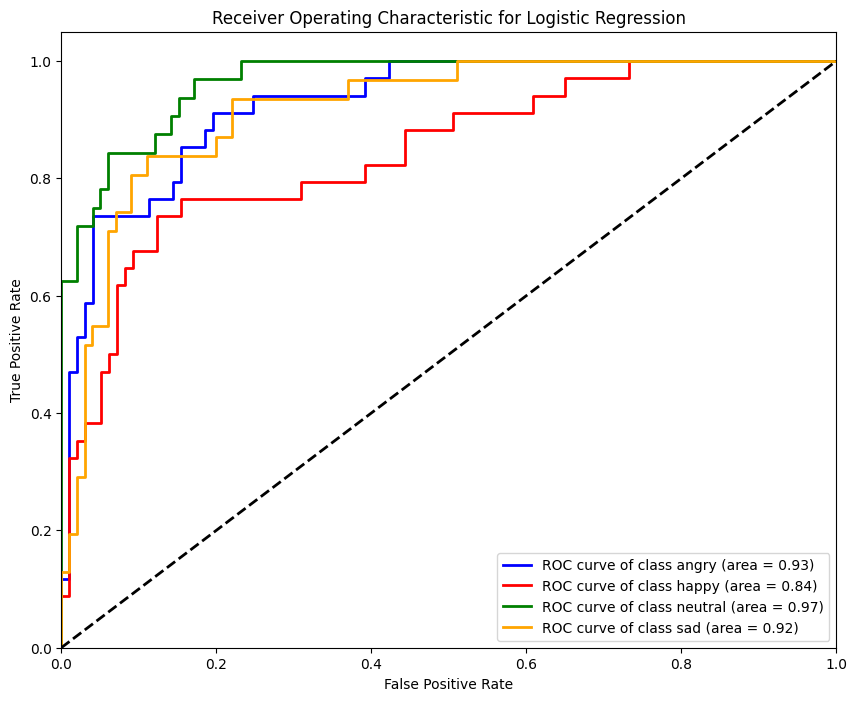

Accuracy Score for Logistic Regression: 0.7175572519083969
Precision Score (weighted) for Logistic Regression: 0.7189430472099214
Recall Score (weighted) for Logistic Regression: 0.7175572519083969
F1 Score (weighted) for Logistic Regression: 0.7142779378281259

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       angry       0.66      0.74      0.69        34
       happy       0.73      0.56      0.63        34
     neutral       0.77      0.84      0.81        32
         sad       0.72      0.74      0.73        31

    accuracy                           0.72       131
   macro avg       0.72      0.72      0.72       131
weighted avg       0.72      0.72      0.71       131

Confusion Matrix for Logistic Regression:
[[25  7  1  1]
 [ 8 19  3  4]
 [ 1  0 27  4]
 [ 4  0  4 23]]


In [7]:
# Initialize the Logistic Regression model with a random state
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
evaluate_model(logistic_model, 'Logistic Regression', X_test, y_test)

# KNN

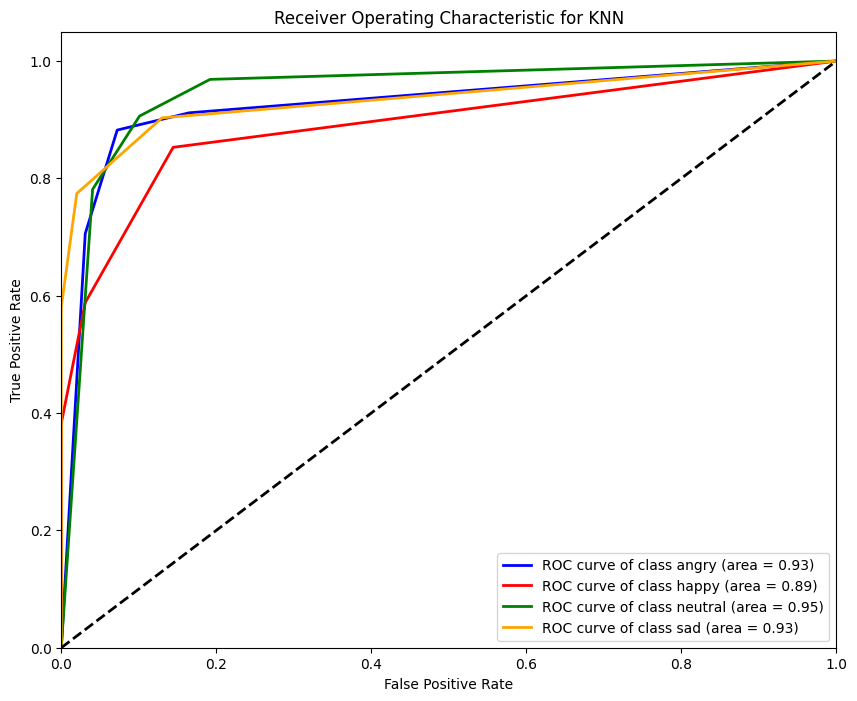

Accuracy Score for KNN: 0.7938931297709924
Precision Score (weighted) for KNN: 0.8128786389964694
Recall Score (weighted) for KNN: 0.7938931297709924
F1 Score (weighted) for KNN: 0.7899418376163945

Classification Report for KNN:
              precision    recall  f1-score   support

       angry       0.72      0.91      0.81        34
       happy       0.87      0.59      0.70        34
     neutral       0.74      0.91      0.82        32
         sad       0.92      0.77      0.84        31

    accuracy                           0.79       131
   macro avg       0.81      0.80      0.79       131
weighted avg       0.81      0.79      0.79       131

Confusion Matrix for KNN:
[[31  1  2  0]
 [ 8 20  5  1]
 [ 2  0 29  1]
 [ 2  2  3 24]]


In [8]:
# Initialize the KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
evaluate_model(knn_model, 'KNN', X_test, y_test)

# Random Forest

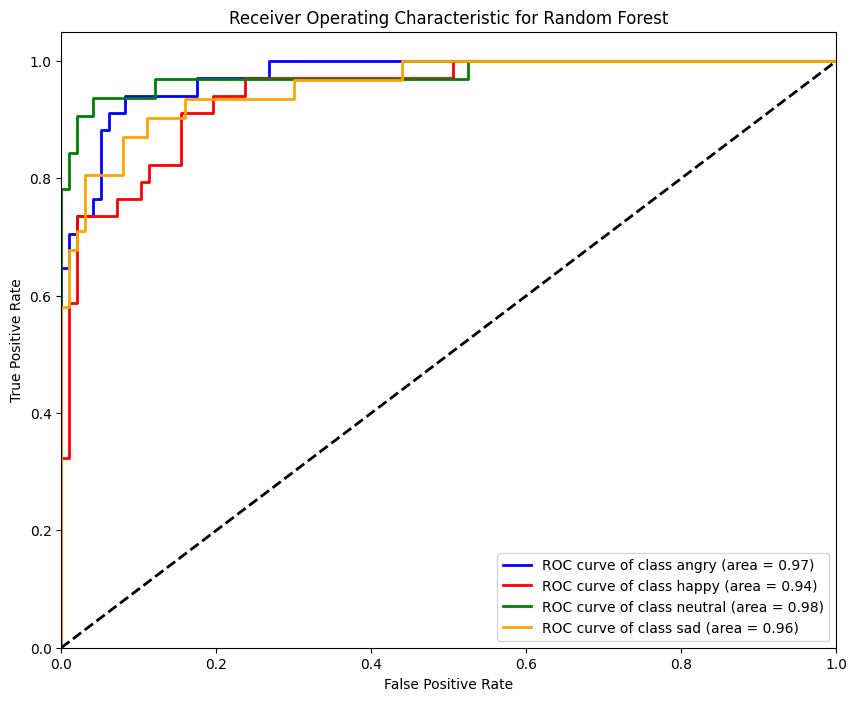

Accuracy Score for Random Forest: 0.7938931297709924
Precision Score (weighted) for Random Forest: 0.801075470988606
Recall Score (weighted) for Random Forest: 0.7938931297709924
F1 Score (weighted) for Random Forest: 0.7887456125410223

Classification Report for Random Forest:
              precision    recall  f1-score   support

       angry       0.71      0.88      0.79        34
       happy       0.83      0.59      0.69        34
     neutral       0.83      0.94      0.88        32
         sad       0.83      0.77      0.80        31

    accuracy                           0.79       131
   macro avg       0.80      0.80      0.79       131
weighted avg       0.80      0.79      0.79       131

Confusion Matrix for Random Forest:
[[30  2  0  2]
 [ 9 20  3  2]
 [ 1  0 30  1]
 [ 2  2  3 24]]


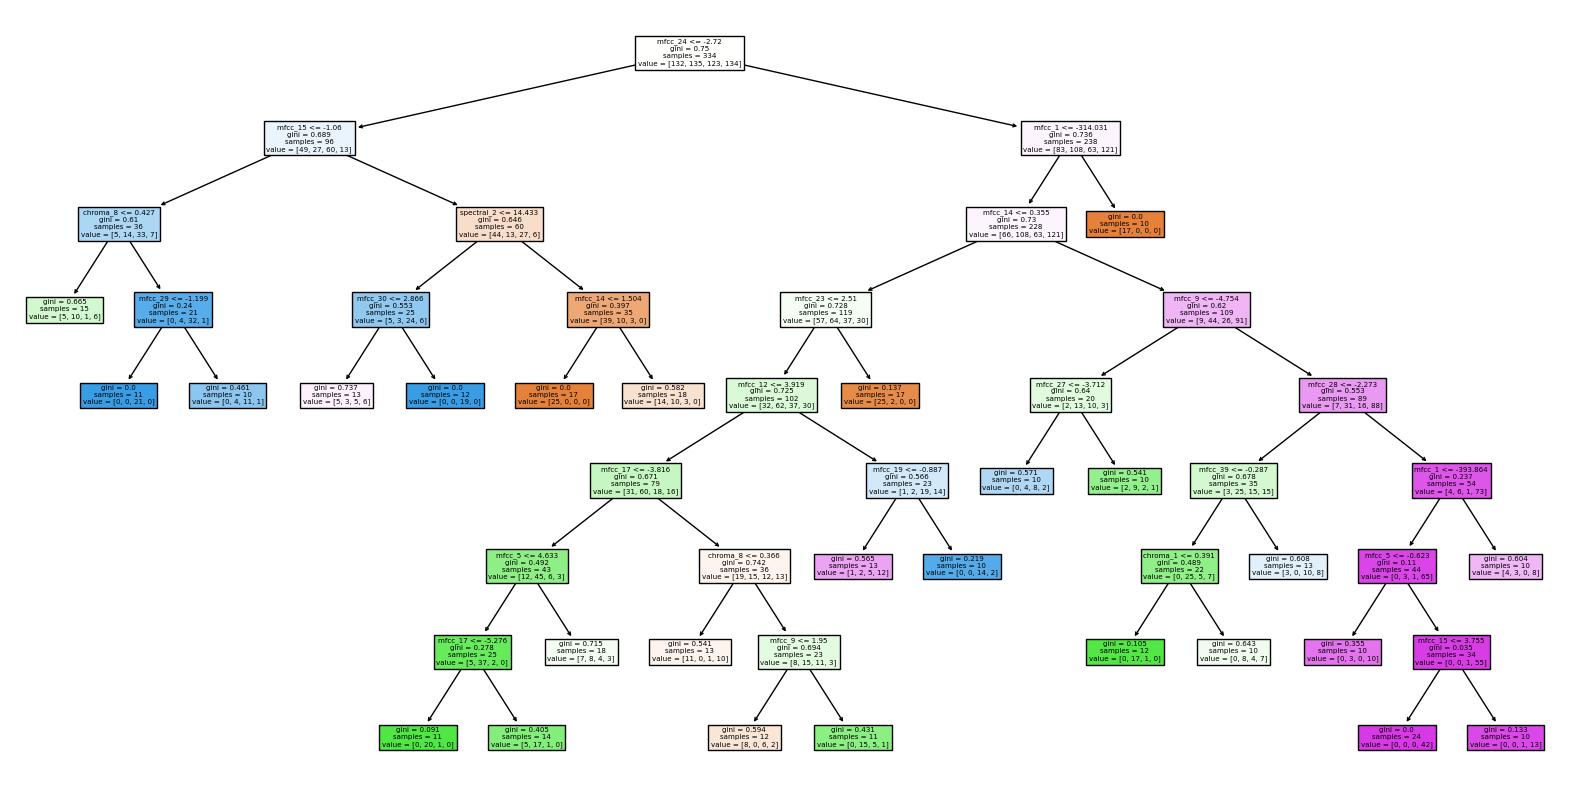

Number of trees in the forest: 200
Maximum depth of trees: 10


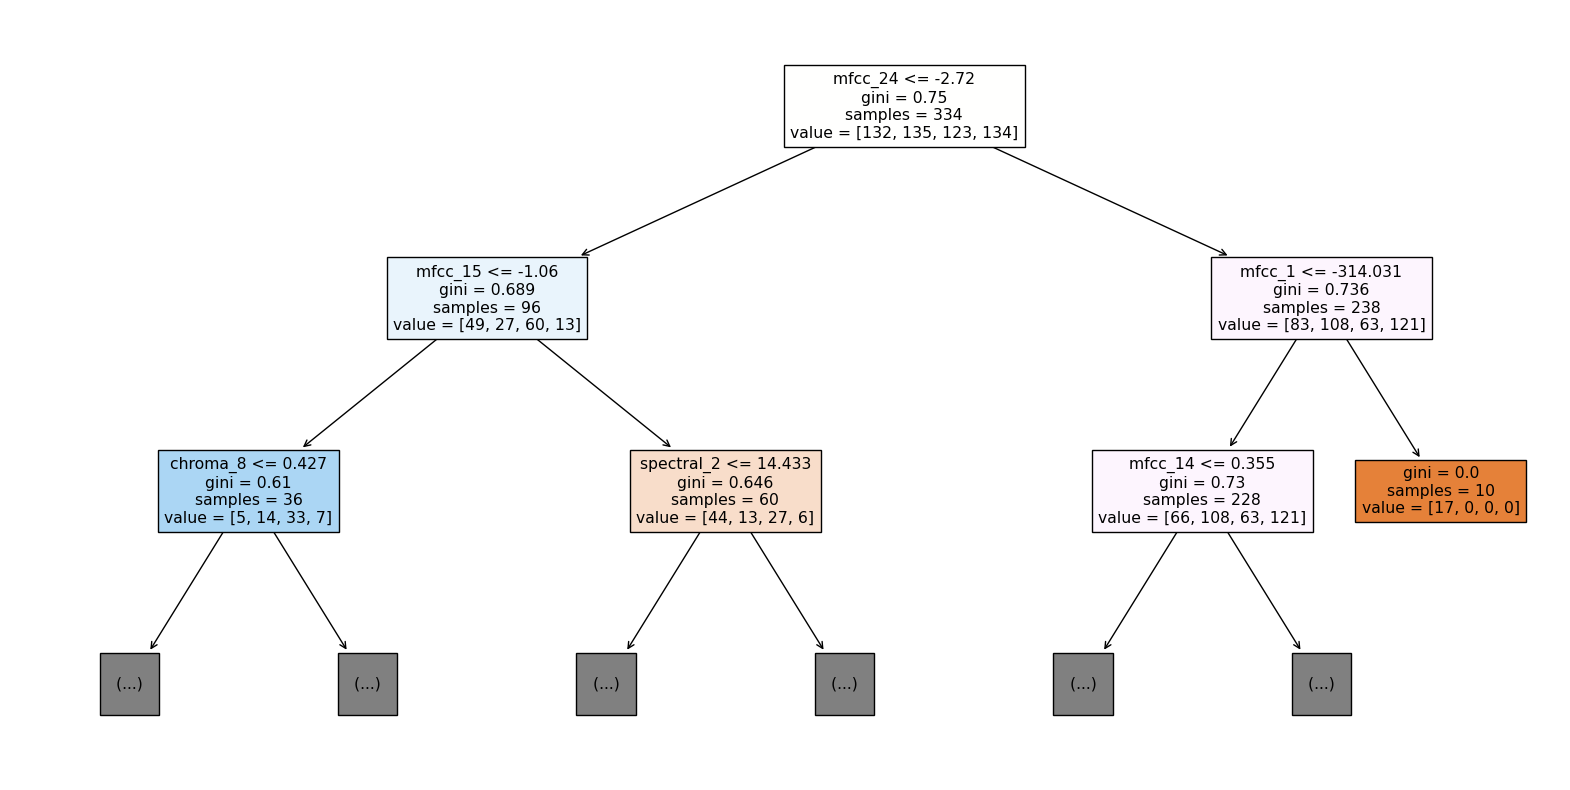

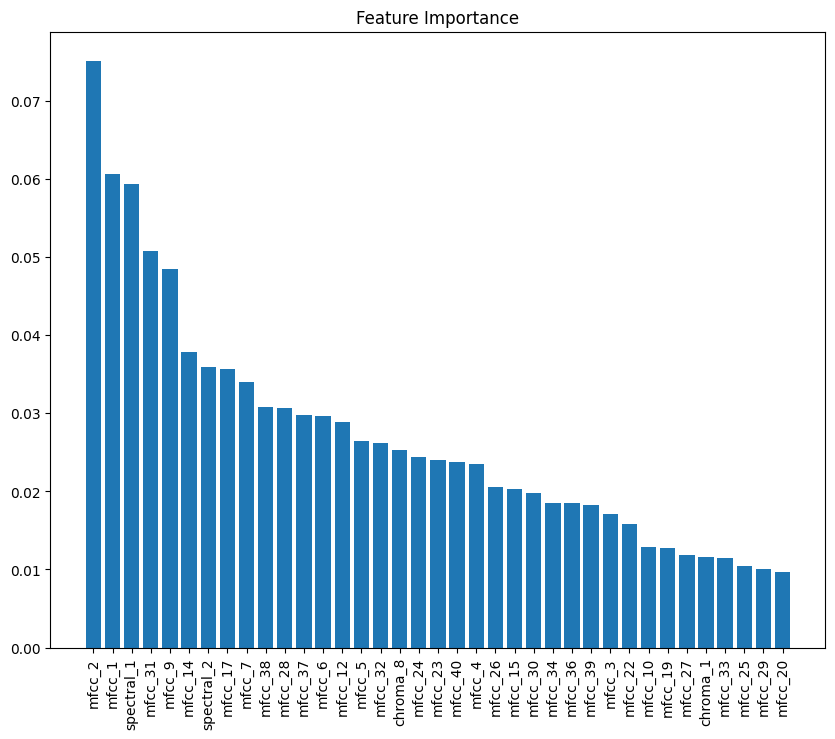

In [36]:
# Initialize the Random Forest model with a random state
# random_forest_model = RandomForestClassifier(random_state=42)

random_forest_model = RandomForestClassifier(
    n_estimators=200,    # Use more trees
    max_depth=10,         # Limit the depth of trees
    min_samples_split=20, # Minimum number of samples required to split an internal node
    min_samples_leaf=10,   # Minimum number of samples required to be at a leaf node
    max_features='sqrt',  # Number of features to consider at each split
    bootstrap=True,        # Use bootstrapping
    random_state=42
)


random_forest_model.fit(X_train, y_train)
evaluate_model(random_forest_model, "Random Forest", X_test, y_test)

# print out the tree diagram
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(random_forest_model.estimators_[0], feature_names=X.columns, filled=True)
plt.show()

# count the number of trees in the forest
n_trees = len(random_forest_model.estimators_)
print(f'Number of trees in the forest: {n_trees}')

# print the deepth of each tree
depths = [estimator.tree_.max_depth for estimator in random_forest_model.estimators_]
print(f'Maximum depth of trees: {np.max(depths)}')

# # print first 5 trees
# for i in range(5):
#     plt.figure(figsize=(20, 10))
#     plot_tree(random_forest_model.estimators_[i], feature_names=X.columns, filled=True)
#     plt.show()

# print first two levels of the first tree
plt.figure(figsize=(20, 10))
plot_tree(random_forest_model.estimators_[0], feature_names=X.columns, filled=True, max_depth=2)
plt.show()


# Feature Importance
importances = random_forest_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()


